In [17]:
!pip install torchinfo
!pip install timm

In [2]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [1]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchinfo import summary 



In [2]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# Create Dataset
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
dataset_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [4]:
dataset = ImageFolder(dataset_dir, transform=tfm)
test_ds = ImageFolder(valid_dir, transform=tfm) 

In [5]:
print(dataset.class_to_idx)


{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [6]:
# Define the percentage of data to use for testing
validation_split = 0.2

# Calculate the length of the test split
vali_length = int(len(dataset) * validation_split)

# Calculate the length of the training split
train_length = len(dataset) - vali_length

# Split the dataset into training and test sets
train_dataset, vali_dataset = random_split(dataset, [train_length, vali_length])

# Length of Train and Test Datasets
LEN_TRAIN = len(train_dataset)
LEN_TEST = len(vali_dataset)
LEN_TEST2 = len(test_ds)

print("len of total (train) dataset {}, len of train {}, len of validation {}".format(len(dataset),len(train_dataset),len(vali_dataset)))
print("len of test dataset {}".format(len(test_ds)))

len of total (train) dataset 70295, len of train 56236, len of validation 14059
len of test dataset 17572


In [7]:
# Create data loaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=32, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, num_workers=2)

In [8]:
# Model
model = resnet18(pretrained=True)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=38)
model = model.to(device)


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
summary(model,input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 38]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [9]:
# Optimiser
optimiser = Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

In [10]:
# Lists to store the training and validation loss & accuracy for each epoch
train_losses = []
val_losses = []

train_accu = []
val_accu = []

for epoch in range(15):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in vali_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            val_loss = loss_fn(test_prob, ytest)
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    
    train_accu.append(ep_tr_acc)
    val_accu.append(ep_test_acc)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Validation_acc: {ep_test_acc}")

100%|██████████| 1758/1758 [04:37<00:00,  6.34batch/s]


Epoch: 0, Time: 5.7111035267512005, Loss: 0.05802140012383461
Train_acc: 0.9575005334661071, Validation_acc: 0.990184223628992


100%|██████████| 1758/1758 [03:36<00:00,  8.12batch/s]


Epoch: 1, Time: 4.437159434954325, Loss: 0.05505090951919556
Train_acc: 0.9875880219076748, Validation_acc: 0.9896151931147308


100%|██████████| 1758/1758 [03:35<00:00,  8.15batch/s]


Epoch: 2, Time: 4.410741190115611, Loss: 0.0041220230050385
Train_acc: 0.9902197880361334, Validation_acc: 0.9865566541005761


100%|██████████| 1758/1758 [03:37<00:00,  8.07batch/s]


Epoch: 3, Time: 4.456661442915599, Loss: 0.00540219247341156
Train_acc: 0.9924959100931787, Validation_acc: 0.9928871185717334


100%|██████████| 1758/1758 [04:08<00:00,  7.08batch/s]


Epoch: 4, Time: 5.060372924804687, Loss: 0.12846191227436066
Train_acc: 0.9926559499253147, Validation_acc: 0.9892595490433175


100%|██████████| 1758/1758 [03:44<00:00,  7.84batch/s]


Epoch: 5, Time: 4.575240782896677, Loss: 0.0007009378168731928
Train_acc: 0.9935272779002774, Validation_acc: 0.9874101998719681


 43%|████▎     | 756/1758 [01:35<02:06,  7.90batch/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_accu, label='Training Accuracy')
plt.plot(val_accu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

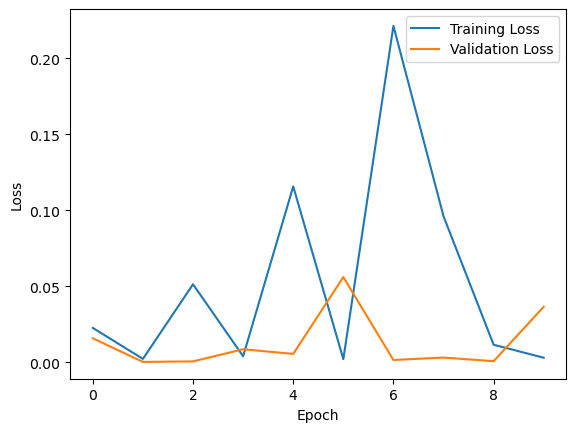

In [21]:
import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
for x,y in train_loader:
    x,y
    break
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [13]:
x = x.to(device)
yprob = model(x.float())

In [19]:
torch.max(yprob,1).indices,y

(tensor([21, 16, 21,  7, 16, 20, 30, 32,  1, 29, 23, 35, 19, 31, 19,  0,  3, 32,
         29, 14, 12,  2, 11, 31, 24, 27, 13,  3,  5,  8, 19,  9],
        device='cuda:0'),
 tensor([21, 16, 21,  7, 16, 20, 30, 32,  1, 29, 23, 35, 19, 31, 19,  0,  3, 18,
         29, 14, 12,  2, 12, 31, 24, 27, 13,  3,  5,  8, 19,  9]))

In [11]:
print("The state dict keys: \n\n", model.state_dict().keys())

The state dict keys: 

 odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight'

In [22]:
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimiser.state_dict()}

torch.save(checkpoint, '5e001lr.pth')

In [13]:
#loading the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [15]:
model = load_checkpoint('../input/5e001lr/5e001lr.pth')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
test_acc = 0
model.eval()
with torch.no_grad():
    for xtest, ytest in test_loader:
        xtest = xtest.to(device)
        test_prob = model(xtest)
        test_prob = test_prob.cpu()

        test_pred = torch.max(test_prob,1).indices
        test_acc += int(torch.sum(test_pred == ytest))

    ep_test_acc = test_acc / LEN_TEST2
print("test dataset accuracy: {}".format(ep_test_acc))

test dataset accuracy: 0.9947643979057592


In [16]:
# Image Samples
sample_1 = '../input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG'
sample_2 = '../input/new-plant-diseases-dataset/test/test/CornCommonRust1.JPG'
sample_3 = '../input/new-plant-diseases-dataset/test/test/PotatoEarlyBlight4.JPG'
sample_4 = '../input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus2.JPG'

sample_list = [sample_1,sample_2,sample_3,sample_4]

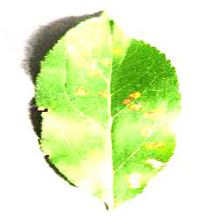

Apple___Cedar_apple_rust


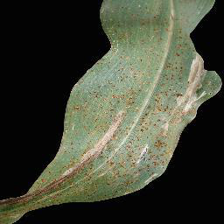

Corn_(maize)___Common_rust_


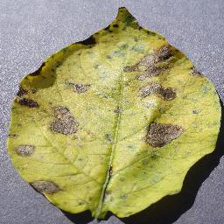

Potato___Early_blight


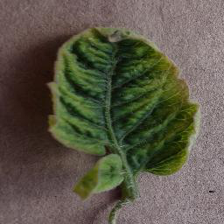

Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [17]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    kv = dataset.class_to_idx
    li = [k for k,v in kv.items() if v == pred]
    print(*li)
